# Classification of Poisonous Mushrooms

### librrary import 

In [1]:
import tensorflow as tf
from tensorflow import keras
import seaborn as sns
import sklearn as sk
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

from os import walk
from sklearn.model_selection import train_test_split
from IPython.display import clear_output

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-1wb2j94f because the default path (/.config/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


In [2]:
print(f"Num GPUs Available: {len(tf.config.experimental.list_physical_devices('GPU'))}")


Num GPUs Available: 1


In [3]:
tf.config.experimental.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [4]:
tf.device('/physical_device:GPU:0')

### constance

In [5]:
"""
dir paths
"""
output_dir = '../models'

"""
trainingt image parameters
"""
img_height = 100
img_width =100
np.random.seed(42)

## Create Data set 

get file path

In [6]:
mypath_ce = '../data/edible mushroom sporocarp'
mypath_ncvc = '../data/edible sporocarp'
mypath_cv = '../data/poisonous mushroom sporocarp'
mypath_nncv = '../data/poisonous sporocarp'

filenames_ce = next(walk(mypath_ce), (None, None, []))[2]
filenames_ncvc = next(walk(mypath_ncvc), (None, None, []))[2]
filenames_cv = next(walk(mypath_cv), (None, None, []))[2]
filenames_nncv = next(walk(mypath_nncv), (None, None, []))[2]



### make stuctured path - mushroom relation

In [7]:
files = []
files.extend( [[1,'ce','data/edible mushroom sporocarp/'+file] for file in filenames_ce] )
#files.extend( [[1,'ncvc','data/edible sporocarp/'+file] for file in filenames_ncvc] )
files.extend( [[0,'cv','data/poisonous mushroom sporocarp/'+file] for file in filenames_cv] )
#files.extend( [[0,'nncv','data/poisonous sporocarp/'+file] for file in filenames_nncv] )

np.random.shuffle(np.asarray(files))

Crate DataFrame by our data

In [8]:
mushrooms = pd.DataFrame(files,columns=['edible', 'type', 'path'])

mushrooms = mushrooms.sample(frac = 1)

mushrooms

,edible,type,path
1079,1,ce,data/edible mushroom sporocarp/edible (709).png
4773,1,ce,data/edible mushroom sporocarp/732_a2AOpcFRwwA...
9546,0,cv,data/poisonous mushroom sporocarp/652_8KyCJUS8...
8274,0,cv,data/poisonous mushroom sporocarp/cv (409).jpg
6433,1,ce,data/edible mushroom sporocarp/0566_excfNs6e4d...
...,...,...,...
11391,0,cv,data/poisonous mushroom sporocarp/304_fF9sgw_c...
10858,0,cv,data/poisonous mushroom sporocarp/221_n-Jj_NnJ...
4898,1,ce,data/edible mushroom sporocarp/0547_I0TAoRXwrs...
4077,1,ce,data/edible mushroom sporocarp/423_oyOACvMD_p4...


### Preprocessing photos from files to dataframe 
- get image from file 
- load image 
- convert image to grayscale
- preprocessing image to array

In [9]:
from PIL import Image

In [10]:
preproc = False 

if preproc:
    images = []

    for image_path in list(mushrooms.path):
        full_path = os.path.join(os.getcwd(),"..",image_path)
    
        #image = mahotas.imread(full_path)
        image = tf.keras.preprocessing.image.load_img(full_path,color_mode='rgb',target_size=(img_height,img_width))
        #image = tf.image.rgb_to_grayscale(image)
    
        
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        images.append(input_arr)
        
    
    images = np.asarray(images)
    np.save('../data/preproc_images',images)
    x = images
else:
    
    images = np.load('../data/preproc_images.npy')
    x = images
images.shape

(11703, 100, 100, 3)

In [11]:
y = np.asarray(mushrooms.edible)
y

array([1, 1, 0, ..., 1, 1, 1])

## Vizualyze images

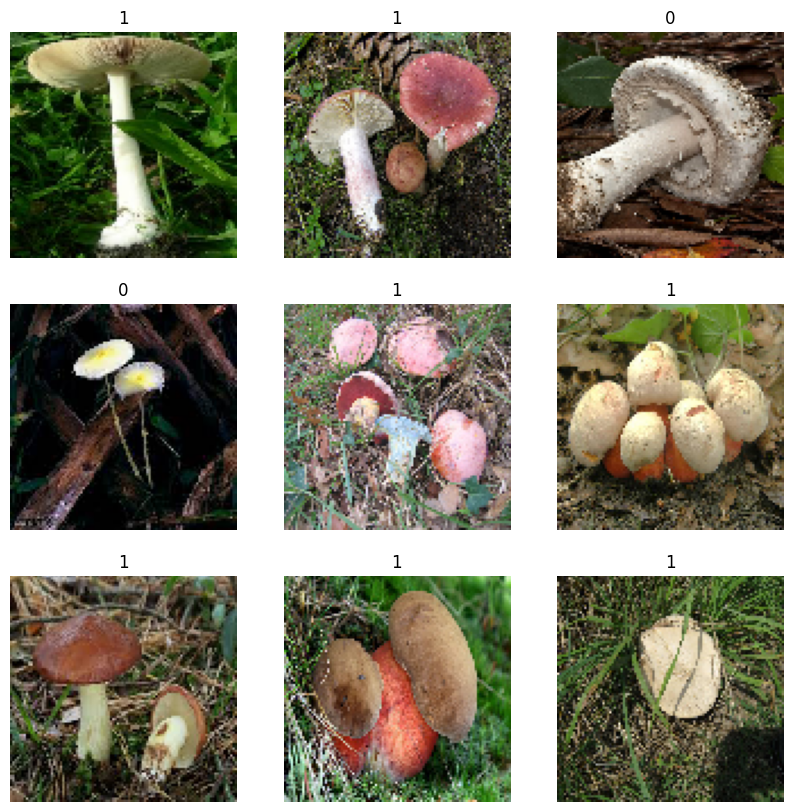

In [12]:
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(x[i].astype("uint8"))
    plt.title(y[i])
    plt.axis("off")
plt.show()

### Count of data in each class 

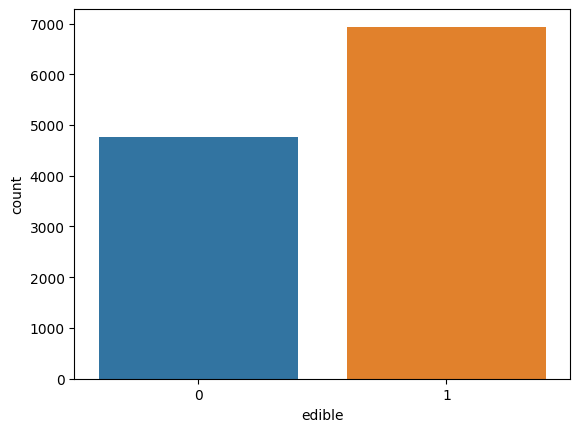

In [13]:
ax = sns.countplot(x="edible", data=mushrooms)
plt.show()

## Create input data 

make train/yest dataset

In [14]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.99, random_state=42)
X_train=np.asarray(X_train)/255
X_test=np.asarray(X_test)/255
X_val, X_train, y_val, y_train = train_test_split(X_train, y_train, test_size=0.99, random_state=2002)

print(np.shape(X_train))

(9269, 100, 100, 3)


In [15]:
print(y_train[0])

1


In [16]:


class PlotLearning(keras.callbacks.Callback):
    
    def on_train_begin(self, logs={}):
        self.metrics = {}
        for metric in logs:
            self.metrics[metric] = []
            

    def on_epoch_end(self, epoch, logs={}):
        # Storing metrics
        for metric in logs:
            if metric in self.metrics:
                self.metrics[metric].append(logs.get(metric))
            else:
                self.metrics[metric] = [logs.get(metric)]
        
        # Plotting
        metrics = [x for x in logs if 'val' not in x]
        
        f, axs = plt.subplots(1, len(metrics), figsize=(15,5))
        clear_output(wait=True)
        
        for i, metric in enumerate(metrics):
            axs[i].plot(range(1, epoch + 2), 
                        self.metrics[metric], 
                        label=metric + f" = {self.metrics[metric][-1]}")
            if logs['val_' + metric]:
                axs[i].plot(range(1, epoch + 2), 
                            self.metrics['val_' + metric], 
                            label='val_' + metric+ f" = {self.metrics['val_' + metric][-1]}")
                
            axs[i].legend()
            axs[i].grid()

        plt.tight_layout()
        plt.show()
        

In [18]:




my_model = tf.keras.Sequential([
    #filters=128, kernel_size=(11,11), strides=(4,4)
    
    
    tf.keras.layers.Conv2D(filters=64, kernel_size=(4,4), activation='relu',
                         input_shape=(100,100,3)),
    
    keras.layers.BatchNormalization(),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),

    
    
    tf.keras.layers.Conv2D(256, kernel_size=(4,4), activation='relu'),
    
    keras.layers.BatchNormalization(),
    
    tf.keras.layers.MaxPooling2D(pool_size=(2,2)),
  

    
    
    tf.keras.layers.Conv2D(256, kernel_size=(2,2), activation='relu'),
    
    keras.layers.BatchNormalization(),
    
    tf.keras.layers.MaxPooling2D(pool_size=(3,3)),
 
    
  tf.keras.layers.Flatten(),
    
 
 
  tf.keras.layers.Dense(2000,activation='sigmoid'),
    
  keras.layers.Dropout(0.5),
    
  tf.keras.layers.Dense(2000,activation='sigmoid'),
    
  keras.layers.Dropout(0.4),
    
    tf.keras.layers.Dense(1000,activation='sigmoid'),
    
  keras.layers.Dropout(0.4),

  tf.keras.layers.Dense(500,activation='sigmoid'),
  keras.layers.Dropout(0.3),
  tf.keras.layers.Dense(1, activation='sigmoid')
])


my_model.compile(
    optimizer="adam",
              loss='binary_crossentropy',
              metrics=['accuracy',tf.keras.metrics.AUC()])
                       
    
modelcheckpoint = tf.keras.callbacks.ModelCheckpoint(filepath=output_dir+
                                  "/mymodel/weights.{epoch:02d}.hdf5")

my_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 97, 97, 64)        3136      
                                                                 
 batch_normalization_4 (Batc  (None, 97, 97, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 48, 48, 64)       0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 45, 45, 256)       262400    
                                                                 
 batch_normalization_5 (Batc  (None, 45, 45, 256)      1024      
 hNormalization)                                                 
                                                      

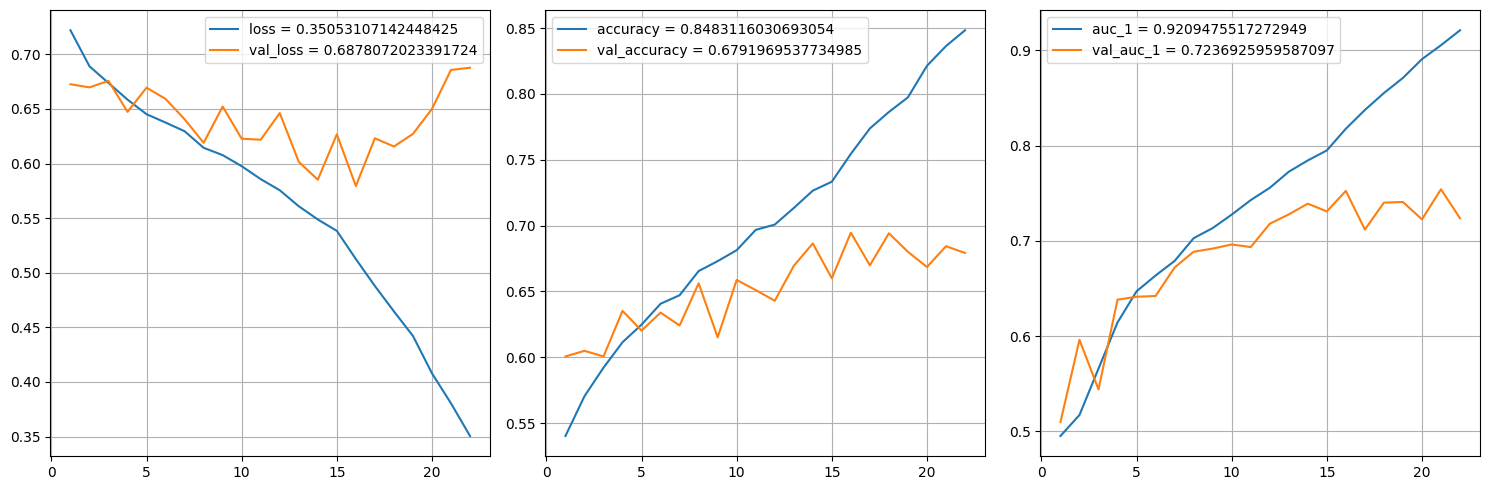

232/232 [==============================] - 64s 274ms/step - loss: 0.3505 - accuracy: 0.8483 - auc_1: 0.9209 - val_loss: 0.6878 - val_accuracy: 0.6792 - val_auc_1: 0.7237
Epoch 23/60
 65/232 [=======>......................] - ETA: 41s - loss: 0.3211 - accuracy: 0.8600 - auc_1: 0.9337

KeyboardInterrupt: 

In [19]:
plot =PlotLearning()

tf.random.set_seed(2002)

my_model.fit(np.array(X_train), np.array(y_train),
          batch_size=40,
          validation_data=(np.array(X_test),np.array(y_test)),
          epochs=60,
          callbacks=[modelcheckpoint, plot])

In [ ]:
checkpoint_path = '../models/mymodel/weights.17.hdf5'
my_model.load_weights(checkpoint_path)

# Re-evaluate the model
loss, acc = my_model.evaluate(X_val, y_val, verbose=2)
print("Restored model, accuracy: {:5.2f}%".format(100 * acc))

# Ather ML models

## prepear Data, feature and labels

In [23]:
import mahotas
import mahotas.demos

In [24]:
preproc = True

if preproc:
    images = []

    for image_path in list(mushrooms.path):
        full_path = os.path.join(os.getcwd(),"..",image_path)
    
        #image = mahotas.imread(full_path)
        image = tf.keras.preprocessing.image.load_img(full_path,color_mode='rgb',target_size=(img_height,img_width))
        image = tf.image.rgb_to_grayscale(image)
    
        
        input_arr = tf.keras.preprocessing.image.img_to_array(image)
        images.append(input_arr)
        
    
    images = np.asarray(images)
    np.save('../data/preproc_images_for_filters',images)
    x = images
else:
    
    images = np.load('../data/preproc_images_for_filters.npy')
    x = images
images.shape

(11703, 100, 100, 1)

In [ ]:
"""
for image_path in list(mushrooms.path):
    full_path = os.path.join(os.getcwd(),"..",image_path)
    
    #image = mahotas.imread(full_path)
    image = tf.keras.preprocessing.image.load_img(full_path,color_mode='rgb',target_size=(img_height,img_width))
    image = tf.image.rgb_to_grayscale(image)
    
        
    input_arr = tf.keras.preprocessing.image.img_to_array(image)
    images.append(input_arr)
    
       
x = images
"""

In [25]:
x = [image.astype(int)for image in x]

In [26]:
y = list(mushrooms.edible)
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.3, random_state=42)

print(np.shape(X_train[0]))

(100, 100, 1)


## Create feature extraction function, using Haralick texture filters

In [27]:
def create_features(images,label):
    features = []
    labels = []
    for mushroom in range(len(images)):
        try:
            features.append(mahotas.features.haralick(images[mushroom].reshape((img_height,img_height))).ravel())
        except:
            print(images[mushroom].shape)
        labels.append(label[mushroom])
    features = np.array(features)
    labels = np.array(labels)
    return (features, labels) 

## extract features

In [28]:
features_train, labels_train = create_features(X_train,y_train)
features_test, labels_test = create_features(X_test,y_test)

## import ML models 

In [29]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import plot_confusion_matrix
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.gaussian_process.kernels import RBF

## Fit all models

In [30]:
names = ["Logistic Regression", "Nearest Neighbors", "Linear SVM", "RBF SVM", "Gaussian Process",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA"]

classifiers = [
    LogisticRegression(),
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025),
    SVC(gamma=2, C=1),
    GaussianProcessClassifier(1.0 * RBF(1.0)),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=5, n_estimators=10, max_features=1),
    MLPClassifier(alpha=1, max_iter=1000),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis()]
scores_train = []
scores_test = []

for name, clf in zip(names, classifiers):
    clf = Pipeline([('preproc', StandardScaler()), ('classifier', clf)])
    clf.fit(features_train, labels_train)
    score_train = clf.score(features_train, labels_train)
    score_test = clf.score(features_test, labels_test)
    scores_train.append(score_train)
    scores_test.append(score_test)

/usr/local/lib/python3.8/dist-packages/sklearn/linear_model/_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/usr/local/lib/python3.8/dist-packages/sklearn/discriminant_analysis.py:878: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


## Make some score board

In [31]:
res = pd.DataFrame(index = names)
res['scores_train'] = scores_train
res['scores_test'] = scores_test
res.columns = ['Train','Test']
res.index.name = "Classifier accuracy"
pd.options.display.float_format = '{:,.2f}'.format
print(res)

                     Train  Test
Classifier accuracy             
Logistic Regression   0.65  0.64
Nearest Neighbors     0.79  0.59
Linear SVM            0.63  0.63
RBF SVM               0.94  0.59
Gaussian Process      0.67  0.66
Decision Tree         0.64  0.62
Random Forest         0.64  0.63
Neural Net            0.65  0.65
AdaBoost              0.66  0.64
Naive Bayes           0.57  0.59
QDA                   0.65  0.63


## Vizualyze models score 

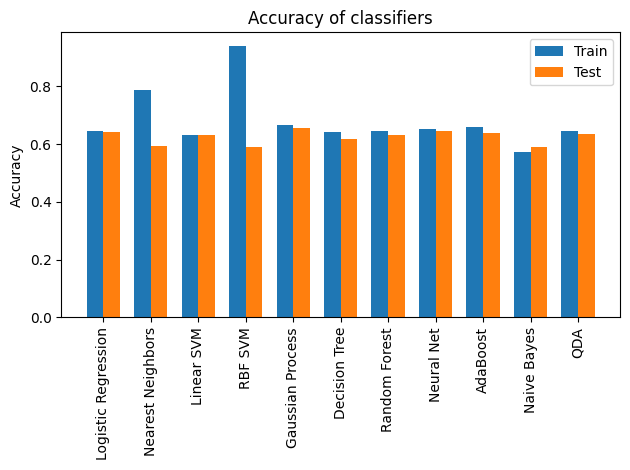

In [32]:
x = np.arange(len(names))  
width = 0.35 

fig, ax = plt.subplots()
rects1 = ax.bar(x - width/2, scores_train, width, label='Train')
rects2 = ax.bar(x + width/2, scores_test, width, label='Test')


ax.set_ylabel('Accuracy')
ax.set_title('Accuracy of classifiers')
ax.set_xticks(x)
plt.xticks(rotation = 90)
ax.set_xticklabels(names)
ax.legend()

fig.tight_layout()

plt.show()